In [57]:
import platform

global systemDivide
if platform.platform().split('-')[0] == 'macOS':
    systemDivide = '/'
else:
    systemDivide = '\\'

import sys
import threading

threading.stack_size(2**27)
sys.setrecursionlimit(10 ** 5)

In [58]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

pairName = 'CHFJPY.csv'

inpData = pd.read_csv(f"testData{systemDivide}{pairName}", index_col=1)
# Какие колонки нужны для работы
columns = ['open', 'high', 'low', 'close']
inpData = inpData[columns]
inpData.index = pd.to_datetime(inpData.index)


initParameters = {
    'yThreshold': 240,
    'rollingMean': 600,
    'fatRollingMean': 1800,
    'timeBarrier': 800,
    'varianceRatioFilter': 1.0,
    'restAfterLoss': 150,
    'restAfterFatProfit' : 50,
    'stopLossPercent': 3.25,
    'takeProfitPercent': 10,
    'varianceRatioCarreteParameter': 10,
    }

# Проверим распределение доходностей на нормальность

3 sigma anomalies 1.275%


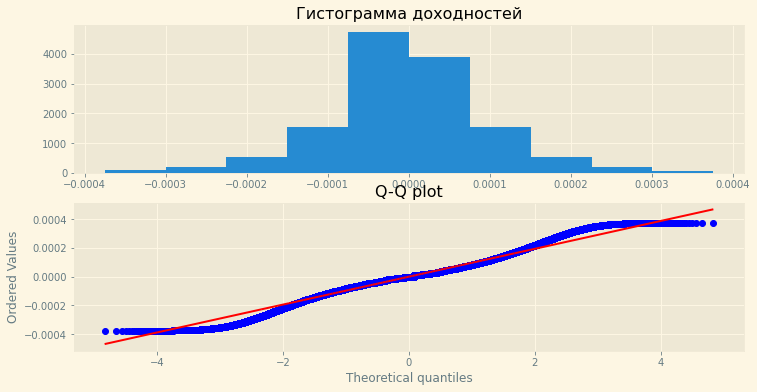

In [59]:
import matplotlib.pylab as plt
from scipy.stats import zscore, probplot

plt.style.use(style='fast')
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('Гистограмма доходностей')
abs_Z_scores = np.abs(zscore(inpData.open.pct_change().iloc[1:]))
filtered = (abs_Z_scores < 3)
print(f'3 sigma anomalies {(1 - sum(filtered) / inpData.shape[0]):.3%}')
bars = plt.hist(inpData.open.pct_change().values[1:][filtered], density=True, )
ax = plt.subplot(2,1,2)

probplot(inpData.open.pct_change().values[1:][filtered], plot=ax)
plt.title(f'Q-Q plot')
plt.show()
del abs_Z_scores, filtered, bars

In [60]:
def create_grid(params: initParameters):
    """
    Создает удобную сетку для дальнейших расчетов
    :param params: начальные init параметры
    :return: словарь из параметров использующийся везде
    """
    capital = 20_000
    slippage = 2
    retParams = {
        # Капитал
        'capital': capital,
        'slippage': slippage,
        # Можно использовать для стоп лоссов и тейков с учетом слипэджа
        'slippagePerCapital': slippage / capital,
        # То какой размах мы будем брать для построения полос Боллинджера. Это и есть X Threshold из файла Евгения
        'yThreshold': round(params['yThreshold'] / 100, 2),
        # Период за который мы строим малую скользяшку
        'rollingMean': params['rollingMean'],
        # Период за который мы строим большую скользяшку
        'fatRollingMean': params['fatRollingMean'],
        # Временной барьер, Максимальное время сколько мы можем держать позицию
        'timeBarrier': params['timeBarrier'],
        # Параметр для определения того что данные MeanReversion/TrendFollowing
        # Используется в VRratio тестах для открытия/удержания позиции
        'varianceRatioFilter': params['varianceRatioFilter'],
        # Сколько времени мы не торгуем после срабатывания стоп лосса
        'restAfterLoss': params['restAfterLoss'],
        # Сколько времени мы не торгуем после закрытия позиции о большую скользяшку
        'restAfterFatProfit' : params['restAfterFatProfit'],
        # Процент стоп лосса
        'stopLossThreshold': round(params['stopLossPercent'] / 100, 3),
        # Процент тэйк профита
        'takeProfitThreshold': round(params['takeProfitPercent'] / 100, 3),
        # Тот период за который мы будем считать Variance Ratio. Те ставя тут к примеру 1500, мы должны будем передавать в функцию
        # VR Ratio 1500 точек данных. Сейчас этот гипермараметр связан с гиперпараметров периода малой скользяшки
        'varianceLookBack': params['rollingMean'] * 2,
        # Чему будет равен временной лаг Q; Q = varianceLookBack // PARAM + 1
        'varianceRatioCarrete': int((params['rollingMean'] * 2) // params['varianceRatioCarreteParameter']) + 1,
    }
    return retParams

def cook_data(df: pd.DataFrame, params) -> pd.DataFrame:
    """
    Подготавливает данные для дальнейшего рассчета стратегии.
    :param df: должен быть open, close, low, high
    :param params: список параметров из create_grid
    :return: данные с полосами Болинджера + логарифмы + возвраты
    """
    df['rollMean'] = df['open'].rolling(window=params['rollingMean']).mean()
    df['rollingStd'] = df['open'].rolling(window=params['rollingMean']).std()
    df['HBBand'] = df['rollMean'] + df['rollingStd'] * params['yThreshold']
    df['LBBand'] = df['rollMean'] - df['rollingStd'] * params['yThreshold']
    df['fatMean'] = df['open'].rolling(window=params['fatRollingMean']).mean()
    df['logOpenPrice'] = np.log(df['open'])
    df['retOpenPrice'] = df['logOpenPrice'].diff()
    return df.iloc[max(params['varianceLookBack'], params['fatRollingMean']):]

def variance_ratio(logTuple: tuple, retTuple: tuple, params: dict) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    buffer_size = len(retTuple)
    means = (1 / buffer_size) * np.sum(retTuple)
    # сдвиг во времени q
    m = params['varianceRatioCarrete'] * (buffer_size - params['varianceRatioCarrete'] + 1 ) * (1 - (params['varianceRatioCarrete'] / buffer_size))
    sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
    subtract_returns = np.subtract(logTuple, np.roll(logTuple, params['varianceRatioCarrete']))[params['varianceRatioCarrete']:]
    _buff_ = np.sum(np.square(subtract_returns - params['varianceRatioCarrete'] * means))

    sigma_b = (1 / m) * _buff_
    result = (sigma_b / sigma_a)
    if result < params['varianceRatioFilter']:
        return True
    else:
        return False

def reverse_variance_ratio(logTuple: tuple, retTuple: tuple, params: dict, timeBorderCounter: int) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param logTuple: tuple из цен открытия включая проверяемую точку
    :param retTuple: tuple из цен открытия включая проверяемую точку
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    if timeBorderCounter < params["varianceLookBack"]:
        buffer_size = len(retTuple)
        means = (1 / buffer_size) * np.sum(retTuple)
        # сдвиг во времени q
        m = timeBorderCounter * (buffer_size - timeBorderCounter + 1 ) * (1 - (timeBorderCounter / buffer_size))
        sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
        subtract_returns = np.subtract(logTuple, np.roll(logTuple, timeBorderCounter))[timeBorderCounter:]
        _buff_ = np.sum(np.square(subtract_returns - timeBorderCounter * means))
        sigma_b = (1 / m) * _buff_
        result = (sigma_b / sigma_a)
        if result > params['varianceRatioFilter']:
            return True
        else:
            return False
    else:
        return False


def open_position(arrowIndex, recursionFilter, dataTuple, params) -> dict:
    """
    Возвращает список с типом сделанной сделки
    Для всех параметров заканчивающихся на Tuple верно следующее: передается как массив tuple.
    Это связанно с повышением эффективности бэктеста и особенностями рекурсии. В real-time будет другая реализация

    :param dataTuple: Список из объектов, необходимых для расчетов. Содержит в себе:
        arrowIndex: Навигация по полному массиву данных. В real-time не нужен
        recursionFilter: ограничитель ошибок связанных с забитием памяти и превышением лимита рекурсии. В real-time не нужен
        LBandTuple: нижняя граница болинджера. Цена посчитанная как actualLightMean - std * {HYPERPARAMETER}
        HBandTuple: верхняя полоса болинджера. Цена посчитанная как actualLightMean + std * {HYPERPARAMETER}.
        LowTuple: low цена. В real-time скорее всего будет неактуально
        HighTuple: high цена. В real-time скорее всего будет неактуально
        OpenTuple: open цена. В real-time скорее всего будет неактуально
        params: список параметров полученных с помощью create_grid
        logTuple: необходим для расчета Variance ratio. Логарифмированные цены
        retTuple: необходим для расчета Variance ratio. Возвраты во времени

    :return: список о сделанной сделке. Нужен такой тип для сокращения возможности ошибки.
    """
    LOGIC_BOOL = False
    _recursion_limit = 10_000

    openDict = {
        'typeOperation': None,
        'position': None,
        'openPrice': None,
        'openIndex': None,
        'stopLossBorder': None,
        'takeProfitBorder': None
    }
    # if нужный для корректной работы нашей конерктной реализации. Мы работаем через рекурсию, поэтому это нужно для того
    # Чтобы не вызывать StackOverflow
    if recursionFilter > _recursion_limit:
        return arrowIndex

    # Проверяем находится ли цена открытия бара выше чем нижняя полоса Боллинджера. Нужно так делать только для бэкстеста
    # Суть в том, что так мы защищаться от возможности ситуации когда все цены находятся находятся ниже полосы из-за например резкого ГЭПА
    # Соответствует сделке о покупке. Проверяем что цена LOW находится ниже нижней полосы Боллинджера.
    # В real-time нужно будет считать HBandTuple[arrowIndex] динамически в зависимости от данных что уже есть
    if (dataTuple["OpenTuple"][arrowIndex] > dataTuple["LBandTuple"][arrowIndex]) and (dataTuple["LowTuple"][arrowIndex] < dataTuple["LBandTuple"][arrowIndex]):
        # Если это так, то убеждаемся что можем открыть сделку проводя тест
        # VR_RATIO (LOOKBACK={HYPERPARAMETER}, time_laq===q={HYPERPARAMETER})
        if variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
            # Формируем удобочитаемый тип return функции
            openDict['typeOperation'] = 'BUY'
            openDict['position'] = params['capital'] / dataTuple["LBandTuple"][arrowIndex]
            openDict['openPrice'] = dataTuple["LBandTuple"][arrowIndex]
            openDict['openIndex'] = arrowIndex
            openDict['stopLossBorder'] = dataTuple["LBandTuple"][arrowIndex] * (1 - params['stopLossThreshold'])
            openDict['takeProfitBorder'] = dataTuple["LBandTuple"][arrowIndex] * (1 + params['takeProfitThreshold'])
            LOGIC_BOOL = True
            return openDict

    # Проверяем находится ли цена открытия бара выше чем нижняя полоса Боллинджера. Соответствует сделке о продаже
    # В real-time нужно будет считать HBandTuple[arrowIndex] динамически в зависимости от данных что уже есть
    elif (dataTuple["OpenTuple"][arrowIndex] < dataTuple["HBandTuple"][arrowIndex]) and (dataTuple["HighTuple"][arrowIndex] > dataTuple["HBandTuple"][arrowIndex]):
        # Если это так, то убеждаемся что можем открыть сделку проводя тест
        # VR_RATIO (LOOKBACK={HYPERPARAMETER}, time_laq===q={HYPERPARAMETER})
        if variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                      retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
            # Формируем удобочитаемый тип return функции
            openDict['typeOperation'] = 'SELL'
            openDict['position'] = -1 * (params['capital'] / dataTuple["HBandTuple"][arrowIndex])
            openDict['openPrice'] = dataTuple["HBandTuple"][arrowIndex]
            openDict['openIndex'] = arrowIndex
            openDict['stopLossBorder'] = dataTuple["HBandTuple"][arrowIndex] * (1 + params['stopLossThreshold'])
            openDict['takeProfitBorder'] = dataTuple["HBandTuple"][arrowIndex] * (1 - params['takeProfitThreshold'])
            LOGIC_BOOL = True
            return openDict

    # В случае, если сделку открыть не получилось, переходим к следующей точке. Вывод - пока что сделку не получилось
    # В real-time это является аналогом ожидания до появления следующих данных и повторения проверки на открытие уже на них
    if not LOGIC_BOOL:
        return open_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                             dataTuple=dataTuple, params=params)

def close_position(arrowIndex, recursionFilter, openDict, dataTuple, params, timeBorderCounter, indicatorVR) -> dict:
    """
    Определяет логику закрытия позиции. Содержит в себе закрытие по Stop_Loss, time_border, закрытие о быстрое скользящее,
    закрытие о долгое скользящее

    Для всех параметров заканчивающихся на Tuple верно следующее: передается как массив tuple.
    Это связанно с повышением эффективности бэктеста и особенностями рекурсии. В real-time будет другая реализация
    :param arrowIndex: Указатель необходимый для перемещения. В real-time не нужен
    :param recursionFilter: Указатель необходимый для работы с рекурсией. В real-time не нужен
    :param openDict: Список состоящий из условий открытия сделки
    :param params: тут передаются все гиперпараметры стратегии
    :param dataTuple: Список из объектов, необходимых для расчетов. Содержит в себе:
        LowTuple: low цена. В real-time скорее всего будет неактуально
        HighTuple: high цена. В real-time скорее всего будет неактуально
        OpenTuple: open цена. В real-time скорее всего будет неактуально
        LightMeanTuple: скользящее среднее за меньший период
        FatMeanTuple: скользящее среднее за больший период
        logTuple: логарифмированные цены
        retTuple: возвраты за историю
    :param timeBorderCounter: счетчик необходимый для возможности закрытия о time-barrier
    :param indicatorVR: логическая величина позволяющая гибко добавлять смену режимов стратегии
    Фактически показывает в каком сейчас режиме работает логика удержания позиции. Достаточно легко добавляется сейчас
    следующие режимы
    1) Попытка закрыться не о скользящее среднее за меньший период, а за больший. Повышает прибыльность одной сделки
    2) Позволяет из режима 1) переходить в нулевой, например когда Variance Ratio с тайм-лагом q=Сколько мы находимся в сделке
    Показывает что данные поменяли тенденцию с meanReversion на TrendFollowing
    :return:
    """
    _recursion_limit = 10_000
    NOT_NONE_SAVER = False

    # Условия для корректной работы рекурсии
    if recursionFilter > _recursion_limit:
        return [arrowIndex, indicatorVR, timeBorderCounter]

    # Условия для закрытие о time-barrier
    if timeBorderCounter >= params['timeBarrier']:
        return {'typeHolding': 'endPeriod', 'closePrice': dataTuple["OpenTuple"][arrowIndex+1],
                        'closeIndex': arrowIndex+1}

    # Условия удержания позиции если мы ставли в ЛОНГ
    elif openDict['typeOperation'] == 'BUY':
        # Стоп лосс условие
        if dataTuple["LowTuple"][arrowIndex] < openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': arrowIndex + params['restAfterLoss']}

        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой. Причина этого такая же как для open_position
        # Читай в чем суть - выше!
        elif (dataTuple["OpenTuple"][arrowIndex] < dataTuple["LightMeanTuple"][arrowIndex]) and (not indicatorVR):
            # Проверяем что можно закрыть лонг о пересечение с малой скользящей
            if dataTuple["HighTuple"][arrowIndex] > dataTuple["LightMeanTuple"][arrowIndex]:
                # Проверяем можно ли продолжить удержание позиции. Делаем это через VariacneRatio за какой-то период
                # arrowIndex - params['varianceLookBack'], где varianceLookBack - гиперпараметр стратегии.
                # Временной лаг Q для VARIANCE_RATIO определяется как время что мы находимся в позиции
                # Если VarianceRatio показывает что данные стали TrendFollowing - мы меняем режим стратегии на попытку закерыться
                # О скользящее среднее за больший период. Так мы получим большую прибыль
                if dataTuple["LightMeanTuple"][arrowIndex] < dataTuple["FatMeanTuple"][arrowIndex]:
                    if not reverse_variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']: arrowIndex],
                                      retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']: arrowIndex],
                                      params=params, timeBorderCounter=timeBorderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                                              openDict=openDict, params=params, dataTuple=dataTuple,
                                              timeBorderCounter=timeBorderCounter+1, indicatorVR=True)

                    else:
                        # Если VR RATIO не показал возможность попытаться закрыться о большую скользяшку, то закрываемся
                        # о малую
                        return {'typeHolding': 'lightCross', 'closePrice': dataTuple["LightMeanTuple"][arrowIndex],
                                'closeIndex': arrowIndex }

                else:
                    # Может быть так, что скольщяшее среднее за больший период находится выше чем скользящее за малый период
                    # Если учесть что мы торгуем на тех инструментах что показывают большую склонность к meanReversion
                    # такая ситуцация говорит нам что нужно как можно скорей сбрасывать позицию.
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': dataTuple["LightMeanTuple"][arrowIndex],
                                'closeIndex': arrowIndex + params['restAfterFatProfit']}

        # Определяет режим работы в случае альтернативной стратегии на которую мы переключаеся в случае выполнения каких-то условий
        if indicatorVR:
            # Аналогично тому что было раньше
            if dataTuple["OpenTuple"][arrowIndex] < dataTuple["FatMeanTuple"][arrowIndex]:
                # Аналогично тому что было раньше
                if dataTuple["HighTuple"][arrowIndex] > dataTuple["FatMeanTuple"][arrowIndex]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': dataTuple["FatMeanTuple"][arrowIndex],
                            'closeIndex': arrowIndex}
                # Даем возможность переключить режим стратегии снова на нулевой. Делаем это если данные снова начали показывать
                # склонность к meanReversion
                # if variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                #       retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                #     indicatorVR = False
    """================================================================================="""
    # Все аналогично, не считая симмертричность
    if openDict['typeOperation'] == 'SELL':
        # Stop Loss
        if dataTuple["HighTuple"][arrowIndex] > openDict['stopLossBorder']:
            return {'typeHolding': 'stopLoss', 'closePrice': openDict['stopLossBorder'],
                        'closeIndex': arrowIndex + params['restAfterLoss']}

        # Smart mean crossing
        # Проверяем адекватное расположение между открытием и скользящей малой
        elif (dataTuple["OpenTuple"][arrowIndex] > dataTuple["LightMeanTuple"][arrowIndex]) and (not indicatorVR):
            # Проверяем что можно закрыть шорт о пересечение с малой скользящей
            if dataTuple["LowTuple"][arrowIndex] < dataTuple["LightMeanTuple"][arrowIndex]:
                # Проверяем можно ли продолжить удержание позиции
                if dataTuple["LightMeanTuple"][arrowIndex] > dataTuple["FatMeanTuple"][arrowIndex]:
                    if not reverse_variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']: arrowIndex],
                                      retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']: arrowIndex],
                                      params=params, timeBorderCounter=timeBorderCounter+1):
                        #   Local Trend Following recursion
                        return close_position(arrowIndex=arrowIndex+1, recursionFilter=recursionFilter+1,
                                              openDict=openDict, params=params, dataTuple=dataTuple,
                                              timeBorderCounter=timeBorderCounter+1, indicatorVR=True)

                    else:
                        # small MA
                        return {'typeHolding': 'lightCross', 'closePrice': dataTuple["LightMeanTuple"][arrowIndex],
                                'closeIndex': arrowIndex }

                else:
                    # emergent exit
                    return {'typeHolding': 'lightCrossEmergent', 'closePrice': dataTuple["LightMeanTuple"][arrowIndex],
                                'closeIndex': arrowIndex + params['restAfterFatProfit']}

        # Ждем пересечение с толстой скользящей
        if indicatorVR:
            if dataTuple["OpenTuple"][arrowIndex] > dataTuple["FatMeanTuple"][arrowIndex]:
                if dataTuple["LowTuple"][arrowIndex] < dataTuple["FatMeanTuple"][arrowIndex]:
                    return {'typeHolding': 'fatExtraProfit', 'closePrice': dataTuple["FatMeanTuple"][arrowIndex],
                            'closeIndex': arrowIndex}
                # if variance_ratio(logTuple=dataTuple["logTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],
                #       retTuple=dataTuple["retTuple"][arrowIndex - params['varianceLookBack']:arrowIndex],params=params):
                #     indicatorVR = False



    if not NOT_NONE_SAVER:
        return close_position(arrowIndex=arrowIndex + 1, recursionFilter=recursionFilter + 1,
                              openDict=openDict, params=params, dataTuple=dataTuple,
                              timeBorderCounter=timeBorderCounter + 1, indicatorVR=indicatorVR)



# Начиная с этого момента просто запускается стратегия в парадигме рекурсии
startParams = create_grid(initParameters)
cookedData = cook_data(df=inpData.copy(), params=startParams)

openStore = {"LBandTuple": cookedData.LBBand, "HBandTuple": cookedData.HBBand,
             "LowTuple": cookedData.low, "HighTuple": cookedData.high, "OpenTuple": cookedData.open,
             "logTuple": cookedData.logOpenPrice, "retTuple": cookedData.retOpenPrice}

holdStore = {"LowTuple": cookedData.low, "HighTuple": cookedData.high, "OpenTuple": cookedData.open,
             "LightMeanTuple": cookedData.rollMean, "FatMeanTuple": cookedData.fatMean,
             "logTuple": cookedData.logOpenPrice, "retTuple": cookedData.retOpenPrice}

RESULT = list()
openPOS = open_position(arrowIndex=startParams['varianceLookBack'], recursionFilter=0, dataTuple=openStore, params=startParams)

closePos = close_position(arrowIndex=openPOS['openIndex'], recursionFilter=0, openDict=openPOS,
                          dataTuple=holdStore, params=startParams, timeBorderCounter=0, indicatorVR=False)

RESULT.append({**openPOS, **closePos})
openPOS = startParams['varianceLookBack'] + closePos['closeIndex']
for i in tqdm(range(450)):
    while type(openPOS) is not dict:
            openPOS = open_position(arrowIndex=openPOS, recursionFilter=0, dataTuple=openStore, params=startParams)

    closePos = int(openPOS['openIndex'] + 1)
    indicatorVR = False

    timeBR = 0
    while type(closePos) is not dict:
            closePos = close_position(arrowIndex=closePos, recursionFilter=0, openDict=openPOS, dataTuple=holdStore,
                                      params=startParams, timeBorderCounter=timeBR, indicatorVR=indicatorVR)
            if type(closePos) == list:
                indicatorVR = closePos[1]
                closePos = closePos[0]
                timeBR = closePos[2]

    total_dict = {**openPOS, **closePos}
    RESULT.append(total_dict)
    openPOS = closePos['closeIndex'] + 1

# RESULT содержит в себе всю нуюную статистику
RESULT = pd.DataFrame(RESULT)

  0%|          | 0/450 [00:00<?, ?it/s]

In [106]:
copy_df = RESULT.copy()
copy_df['profit'] = (RESULT["position"] * (RESULT["closePrice"] - RESULT["openPrice"]) - startParams['slippage'] if (RESULT["typeOperation"] == 'BUY').bool else abs(RESULT["position"]) * (RESULT["openPrice"] - RESULT["closePrice"]) - - startParams['slippage'])
print('Total pnl:', round(copy_df.profit.cumsum().iloc[-1], 2))

Total pnl: 12.04


In [62]:
print(f"W={copy_df[copy_df.profit > 0].shape[0] / copy_df.shape[0]:.2%}, L = {copy_df[copy_df.profit < 0].shape[0] / copy_df.shape[0]:.2%}")
print(f'average profit of a positive trade: {copy_df[copy_df.profit > 0].profit.mean():.2f}')
print(f'average profit of a negative trade: {copy_df[copy_df.profit < 0].profit.mean():.2f}')

W=67.63%, L = 32.37%
average profit of a positive trade: 19.07
average profit of a negative trade: -39.76


In [63]:
copy_df[copy_df.profit < 0].groupby(by='typeHolding').describe()

position                                                 \
                      count       mean         std         min         25%   
typeHolding                                                                  
endPeriod             102.0  21.503003  181.107885 -186.430419 -181.546046   
fatExtraProfit          5.0 -36.044775  199.071222 -183.877846 -181.235165   
lightCross             33.0   4.871752  184.511401 -184.211039 -182.701202   
lightCrossEmergent      6.0  -0.166234  197.388783 -182.770412 -180.321548   

                                                       openPrice              \
                           50%         75%         max     count        mean   
typeHolding                                                                    
endPeriod           177.782319  182.548309  185.980548     102.0  110.234433   
fatExtraProfit     -179.148511  181.574759  182.462890       5.0  110.103948   
lightCross          175.033182  181.789985  184.586151      33.0  110.067529   
lightCrossEmergent    0.128990  179.236095  183.048295       6.0  111.026975   

                    ... closeIndex           profit                        \
                    ...        75%       max  count       mean        std   
typeHolding         ...                                                     
endPeriod           ...   232720.5  330037.0  102.0 -46.286749  37.155021   
fatExtraProfit      ...   268202.0  325731.0    5.0  -2.292600   1.727734   
lightCross          ...   262805.0  328783.0   33.0 -31.560691  27.023645   
lightCrossEmergent  ...   206315.0  265721.0    6.0  -5.061013   2.678003   

                                                                           
                           min        25%        50%        75%       max  
typeHolding                                                                
endPeriod          -194.201635 -61.776619 -40.893181 -21.165909 -0.318823  
fatExtraProfit       -5.192639  -2.403117  -1.633690  -1.515860 -0.717694  
lightCross          -99.089730 -50.382965 -22.857119 -13.011637 -0.189519  
lightCrossEmergent   -8.205376  -7.122317  -5.366855  -2.666842 -1.952682  

[4 rows x 64 columns]

In [64]:
copy_df.groupby(by='typeHolding').describe()

position                                                 \
                      count       mean         std         min         25%   
typeHolding                                                                  
endPeriod             112.0  13.259779  181.703233 -186.430419 -181.486379   
fatExtraProfit        177.0  -0.725290  181.894403 -184.996279 -181.618146   
lightCross             48.0   7.176454  183.749655 -184.211039 -182.794520   
lightCrossEmergent    114.0  -0.320258  182.445152 -186.351155 -182.460322   

                                                       openPrice              \
                           50%         75%         max     count        mean   
typeHolding                                                                    
endPeriod           176.413248  182.535641  185.980548     112.0  110.311522   
fatExtraProfit     -174.734100  182.579100  186.684023     177.0  110.302108   
lightCross          175.103593  182.452550  184.586151      48.0  109.939875   
lightCrossEmergent    0.068349  181.928710  185.280238     114.0  110.138086   

                    ... closeIndex           profit                        \
                    ...        75%       max  count       mean        std   
typeHolding         ...                                                     
endPeriod           ...  231365.50  330037.0  112.0 -41.369299  38.905310   
fatExtraProfit      ...  248323.00  330953.0  177.0  20.926852  13.142023   
lightCross          ...  265454.25  328783.0   48.0 -17.003265  31.643503   
lightCrossEmergent  ...  244983.25  330848.0  114.0  15.416692  10.654361   

                                                                            
                           min        25%        50%        75%        max  
typeHolding                                                                 
endPeriod          -194.201635 -59.784999 -34.341112 -14.973609  31.208081  
fatExtraProfit       -5.192639  11.185367  20.214834  28.072768  76.079316  
lightCross          -99.089730 -30.866905 -13.530133   5.665079  30.630715  
lightCrossEmergent   -8.205376   9.696088  13.859434  20.406250  63.733377  

[4 rows x 64 columns]

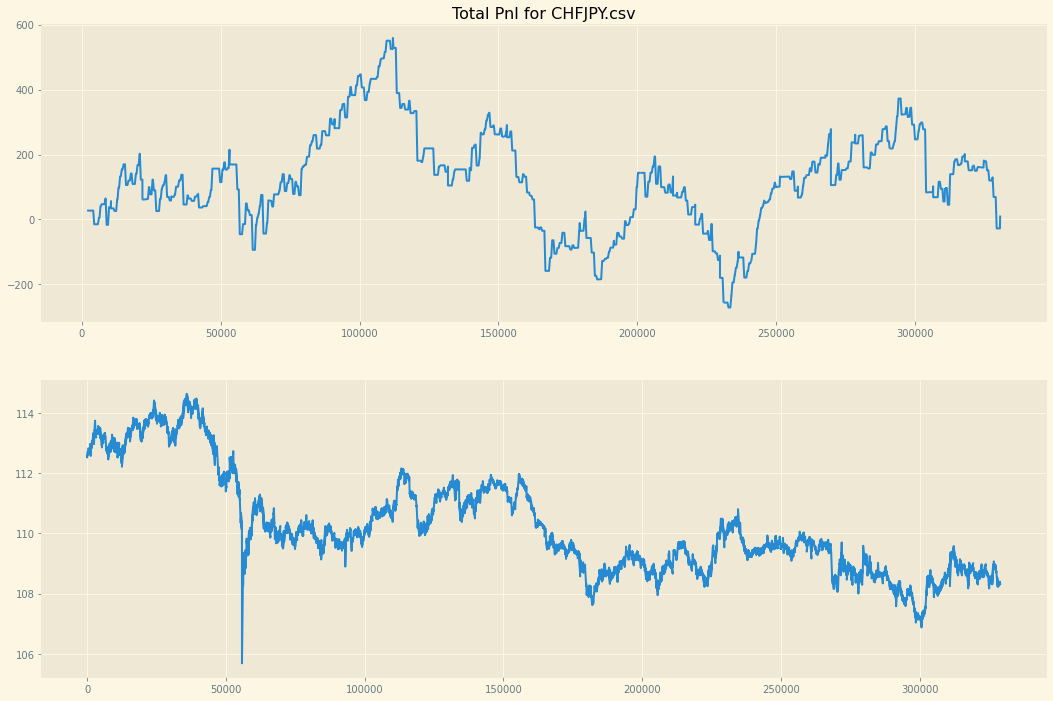

In [117]:
copy = copy_df.copy()
copy.index = copy.openIndex
stepDF = pd.DataFrame(index=pd.RangeIndex(min(copy_df.openIndex), max(copy_df.openIndex)))
stepPnl = stepDF.merge(copy, left_index=True, right_index=True, how='outer').profit.replace(np.nan, 0).cumsum()
del copy, stepDF

plt.figure(figsize=(18,12))
plt.style.use('Solarize_Light2')
plt.subplot(2,1,1)
plt.plot(stepPnl)
plt.title(f'Total Pnl for {pairName}')
plt.subplot(2,1,2)
plt.plot(range(0, openStore["OpenTuple"].iloc[min(RESULT.openIndex):max(RESULT.openIndex)].shape[0]), openStore["OpenTuple"].iloc[min(RESULT.openIndex):max(RESULT.openIndex)])
plt.show()